function value =  0.000119819708674
variable values =  [ 1.00691541  1.01303013]
evaluation number =  334


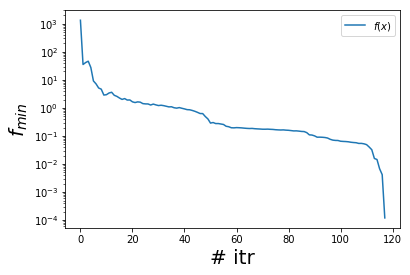

In [41]:
# CMAES for Rosenbrock function
import numpy as np
from numpy.random import seed
import random
import math
import matplotlib.pyplot as plt


def mml_CMA_ES_c(f, g, x0):
    # mu/mu-lambda CMA-ES with Constraints       
    # check input
    #assert sgm0 > 0; assert maxit > 0; 
    # pass input to local variables
    l = len(x0); sgm = sgm0; x = x0; fx = f(x); 

    # initalize parameters - selection
    n = 4 + 3*np.log(l)//1  # sample size
    n= n.astype(np.int64)   # convert to int64
    #weights = np.log(mu+1/2)-np.log(1:mu).T
    mu = n // 2             # best value size

    # initalize parameters - adaptation
    cc = 4 / n # path length covariance matrix
    cs = 4 / n # path length sigma
    c1 = 2 / n**2 # learning rate for rank-one update of C
    cmu = mu / n**2 # learning rate for rank-mu update of C
    if c1 + cmu > 1:
        cmu = 1 - c1
    ds = 1 + (mu / n)**0.5 # damping for sigma
    w = 1 / (0.3 * n * mu)**0.5
    ExpN=l**0.5*(1-1/(4*l)+1/(21*l**2)) # expectation of Normal_Dist(0,Identity)

    # initialize storage
    ps = np.zeros(l)  
    pc = np.zeros(l)
    B = np.identity(l)
    D = np.identity(l)
    C = (B.dot(D)).dot((B.dot(D)).T) # covariance matrix
    s_itr = 0 # total amount of sampling 
    icount=0
    val = [] # function value 
    xni_fxni = np.zeros((l+1,n))  # xni, fxni value storage
    #yni = np.zeros((l,n))
    #fxni = np.zeros(1,n)
    # main loop
    while s_itr < maxit:
        icount=icount+1
        list_x[icount-1] = x
        # sampling loop
        for i in range(0, n):
            # sample 1 point
            xn0 = x + sgm * (B.dot(D)).dot(np.random.randn(l))

            # constraint handling
            j = 0
            while True:
                if np.any(g(xn0) > 0):
                    xn0 = x + sgm * (B.dot(D)).dot(np.random.randn(l))
                else:
                    break
                if j >= n*n*n:
                    print ('WARNING: Iteration Stopped Near Constraint')
                    print ('total sampling = ', s_itr)
                    print ('function value = ', fx)
                    print ('variable values = ', x)
                    return fx,x,np.array(val)
                j += 1
                s_itr +=1
            
            # store values
            xni_fxni[0:l,i] = xn0 # calculate xni
            xni_fxni[l,i] = f(xni_fxni[0:l,i]) # calculate fxni
            s_itr += 1

        # compute mean point and value for mu best points 
        xni_fxni = xni_fxni[:,xni_fxni[l,:].argsort()]  # rank based on fxn values
        yni = (xni_fxni[0:l,0:mu] - np.tile(x,(mu,1)).T) / sgm 
        xn = np.sum(xni_fxni[0:l,0:mu],axis=1) / mu # compute mean xni
        yn = (xn - x) / sgm # compute yn from xn
        fxn = f(xn) # compute function value at x mean 
        
        if fxn <= (1+np.exp(-1/0.99**(s_itr/n)))*fx:
            # step-size control
            ps = (1-cs)*ps + (cs*(2-cs)*mu)**0.5 * B.dot(yn)
            sgm = sgm * np.exp((cs/ds)*( np.linalg.norm(ps)/ExpN - 1))
            
            # covariance matrix adaptation
            hs = np.heaviside(1.5*n**0.5-np.linalg.norm(ps),0)
            pc = (1-cc)*pc + hs * (cc*(2-cc)*mu)**0.5 * yn
            Co = 0
            for i in range(0,mu):
                Co = Co + w*np.outer(yni[:,i],yni[:,i])
            C = (1-c1-cmu)*C + c1*np.outer(pc,pc) + cmu*Co

            # eigen decomposition
            C = np.tril(C) + np.triu(C.T,1) # force symmetry
            D,B = np.linalg.eig(C)   #eigen decomposition
            D = np.diag(D)**0.5

            # update values
            x = xn
            fx = fxn
            val.append(fx)
    return fx,x,np.array(val),icount

# Test function 
def rosen(x):
    n = len(x)
    f = sum((100*(x[i]**2 - x[i+1])**2 + (x[i]-1)**2) for i in range(0,n-1))
    return f
def g(x):
    # x > 2 => 2 - x < 0 
    return np.array([])
sgm0=0.5
maxit=2000
mineps=1e-4
list_x = [0]*maxit
ans4 = mml_CMA_ES_c(rosen, g, np.array([-3,2]))
print ('function value = ', ans4[0])
print ('variable values = ', ans4[1])
print ('evaluation number = ', ans4[3])
plt.semilogy(ans4[2], label='$f(x)$')
plt.ylabel('$f_{min}$',fontsize=20)
plt.xlabel('# itr', fontsize=20)
plt.legend()
N=ans4[3]
list_x=list_x[0:N]


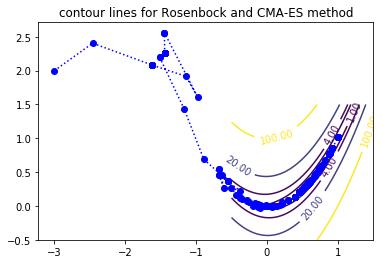

In [42]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def RosenbrockB(x,y):
    return 100*(y-x**2)**2+(x-1)**2

x, y = np.meshgrid(np.linspace(-0.5,1.5, 200), np.linspace(-0.5,1.5, 200))
z = RosenbrockB(x,y)
graphe = plt.contour(x,y,z,[1, 4,20,100])

xk_1 = [list_x[k][0] for k in range(N)] 
xk_2 = [list_x[k][1] for k in range(N)]
plt.plot(xk_1, xk_2, "b:o") #x_k pour methode pattern search

plt.clabel(graphe,inline=1,fontsize=10,fmt='%3.2f')
plt.title("contour lines for Rosenbock and CMA-ES method")
plt.show()
